In [48]:
import pandas as pd

# 데이터 로드
df = pd.read_csv("./wine_review.csv")
print(df.info())  # 데이터프레임 정보 출력

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2890 entries, 0 to 2889
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    2890 non-null   object 
 1   asins                 870 non-null    object 
 2   brand                 2825 non-null   object 
 3   categories            2890 non-null   object 
 4   dateAdded             2890 non-null   object 
 5   dateUpdated           2890 non-null   object 
 6   descriptions          2738 non-null   object 
 7   dimension             1838 non-null   object 
 8   ean                   2166 non-null   object 
 9   flavors               151 non-null    object 
 10  keys                  2890 non-null   object 
 11  manufacturer          849 non-null    object 
 12  manufacturerNumber    2457 non-null   object 
 13  name                  2890 non-null   object 
 14  reviews.date          2552 non-null   object 
 15  reviews.dateAdded    

In [49]:
# 필요없는 컬럼 제거
df = df[['reviews.text', 'reviews.rating']] 

In [50]:
# 결측값 제거
df = df.dropna(subset=['reviews.text', 'reviews.rating'])  # 결측치가 있는 행 제거
print(df.info())  # 전처리 후 데이터프레임 정보 출력

<class 'pandas.core.frame.DataFrame'>
Index: 2444 entries, 0 to 2889
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.text    2444 non-null   object 
 1   reviews.rating  2444 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.3+ KB
None


In [51]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# NLTK 데이터 다운로드
nltk.download('punkt')  # 토큰화를 위한 데이터 다운로드
nltk.download('wordnet')  # 표제어 추출을 위한 데이터 다운로드
nltk.download('stopwords')  # 불용어 제거를 위한 데이터 다운로드
stop_words = set(stopwords.words('english'))  # 영어 불용어 세트 생성

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
def preprocess_text(text):
    # 텍스트 전처리 함수: 토큰화 및 불용어 제거
    tokens = word_tokenize(text.lower())  # 소문자로 변환하고 토큰화
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # 알파벳과 숫자로만 구성된 토큰 선택
    return ' '.join(tokens)  # 전처리된 텍스트 반환

df['processed_text'] = df['reviews.text'].apply(preprocess_text)  # 리뷰 텍스트에 전처리 함수 적용

In [53]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

df['processed_text'] = df['processed_text'].apply(lemmatize_text)


In [54]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [55]:
def analyze_sentiment(text):
    score = sia.polarity_scores(text)
    return score['compound']

df['sentiment_score'] = df['reviews.text'].apply(analyze_sentiment)


In [56]:
def sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(sentiment_category)


/tmp/ipykernel_15215/956477363.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


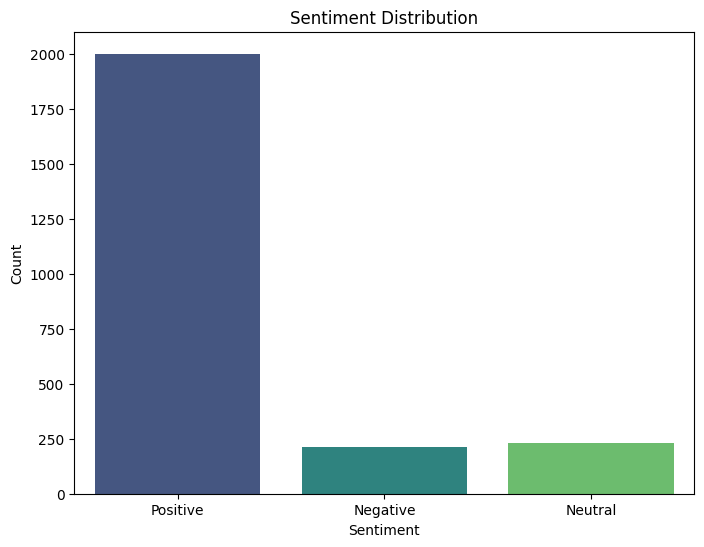

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# 감정 분포 시각화
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


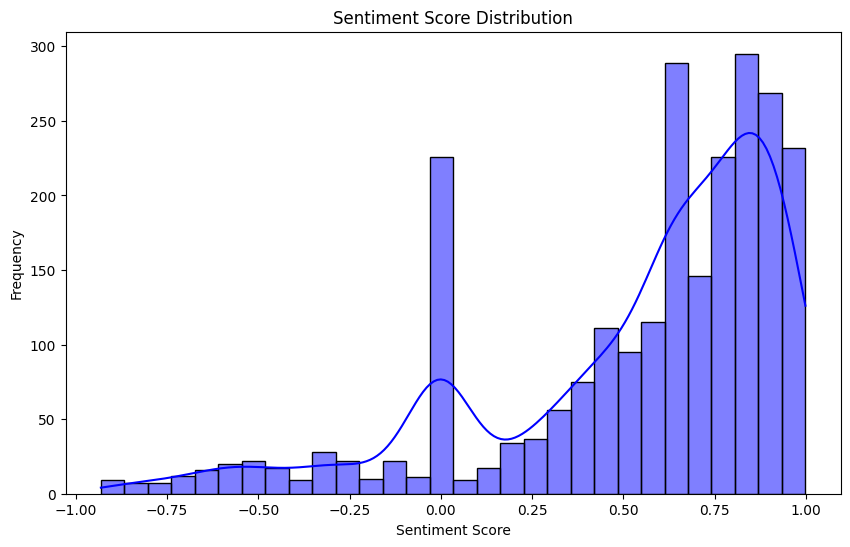

In [58]:
# 감정 점수 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment_score'], bins=30, kde=True, color='blue')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [59]:
from sklearn.model_selection import train_test_split

X = df['processed_text']
y = df['reviews.rating']
y = (y >= 3).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_tfidf, y_train)

best_model = grid.best_estimator_
print("Best Hyperparameters:", grid.best_params_)

Best Hyperparameters: {'C': 100}


In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.decision_function(X_test_tfidf))

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

Accuracy: 0.9693251533742331
Precision: 0.9710144927536232
Recall: 0.997872340425532
F1 Score: 0.9842602308499475
ROC-AUC: 0.8927211646136619


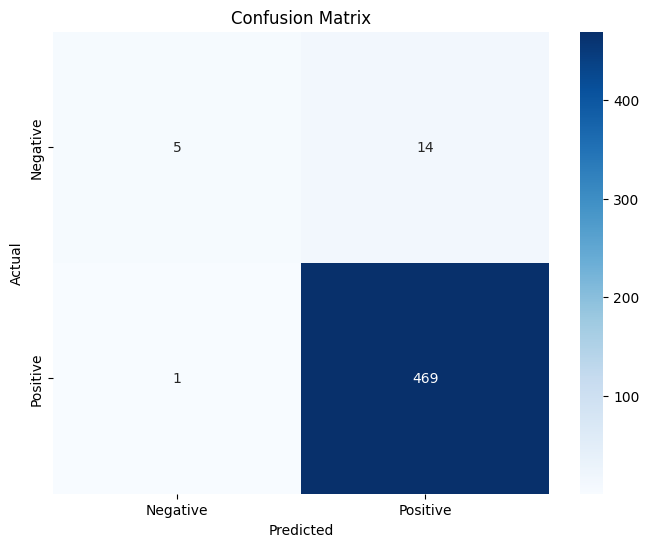

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted') # x축 레이블 설정
plt.ylabel('Actual')  # y축 레이블 설정
plt.title('Confusion Matrix') # 그래프 제목 설정
plt.show()# 그래프 출력

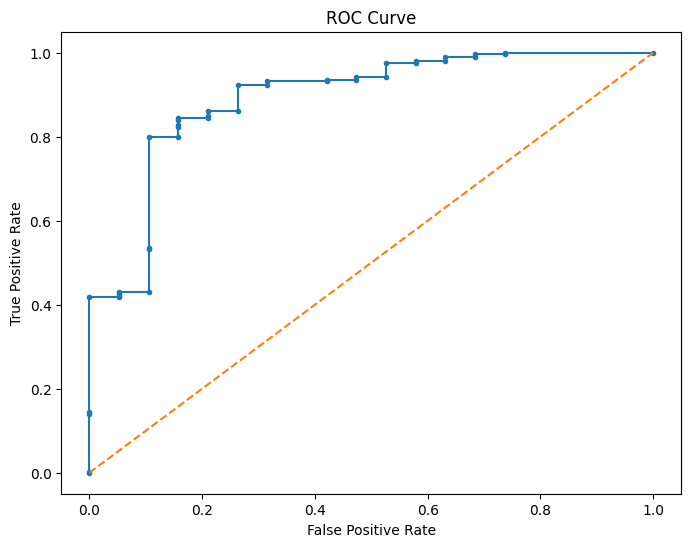

In [64]:
fpr, tpr, thresholds = roc_curve(y_test, best_model.decision_function(X_test_tfidf))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')  # x축 레이블 설정
plt.ylabel('True Positive Rate') # y축 레이블 설정
plt.title('ROC Curve') # 그래프 제목 설정
plt.show()# 그래프 출력